In [2]:
%pip install opencv-python imutils

StatementMeta(, 9cc519e4-dd2e-4e51-88e9-d7ddbfe51643, -1, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 56.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... - done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25838 sha256=602521eecd3173598924de8ec7802d60e5d3ea97b588851e6c29bdcb57f4b2b8
  Stored in directory: /home/trusted-service-user/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils

[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: /nfs4/pyenv-ad6d8d34-2e94-47db-8d15-fd234062bbfe/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
print("Number of available cores:", num_cores)

StatementMeta(, 9cc519e4-dd2e-4e51-88e9-d7ddbfe51643, 10, Finished, Available)

Number of available cores: 16


Define a function tat takes a pandas dataframe and since there are diffrent seasons in the training set and diffrent number of images per season and different images per season. By looking at the first few chracters of the seq_id we can know which season an image belongs to. 

This function takes a single argument `df`, which is the pandas DataFrame containing the `seq_id` column. The function first extracts the season from the `seq_id` column using a lambda function, and then counts the number of sequences in each season using the `value_counts` method of the pandas Series object. The counts are sorted by season using the `sort_index` method.

The function then replaces the `'SER_'` prefix in the season labels with an empty string for easy visibility, and creates a bar plot using `plt.bar`. The x-axis represents the season labels and the y-axis represents the number of sequences in each season. Finally, the function displays the plot using `plt.show`.

You can call this function with your DataFrame `df_train` to plot the number of sequences in each season. For example, you can call `plot_season_counts(df_train)` to plot the season counts.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_season_counts(df, title="Number of Sequences per Season"):
    # Extract the season from the seq_id column using a lambda function
    df['season'] = df.seq_id.map(lambda x: x.split('#')[0])

    # Count the number of sequences in each season, and sort the counts by season
    season_counts = df.season.value_counts().sort_index()

    # Replace 'SER_' prefix in season labels with an empty string for easy visibility
    season_labels = [s.replace('SER_', '') for s in season_counts.index]

    # Create a bar plot where the x-axis represents the season and the y-axis represents the number of sequences in that season
    sns.barplot(x=season_labels, y=season_counts.values)
    plt.xlabel('Season')
    plt.ylabel('Number of sequences')
    plt.title(title)
    plt.show()

StatementMeta(, 9cc519e4-dd2e-4e51-88e9-d7ddbfe51643, 11, Finished, Available)

**Load Data**

Read the annotations data from the lakehouse which forms our traininng set. from this we get information about each season's sequences and labels uisng this data which provided linka between the image_ids and sequences as well as what category is ins a given sequence.

We filter out the relevant columns we'll need , *i.e season, seq_id, category_id, image_id and date_time*. We also need to filter out all records whose category_id is greater than 1 to exclue all empty and huma images which are not relevant for tgis training. 

We also remove any null values in the image_id column and drop any duplicate lrows, finally convert the spark df to a pandas dataframe for easier manipulation.


StatementMeta(, 9cc519e4-dd2e-4e51-88e9-d7ddbfe51643, 12, Finished, Available)

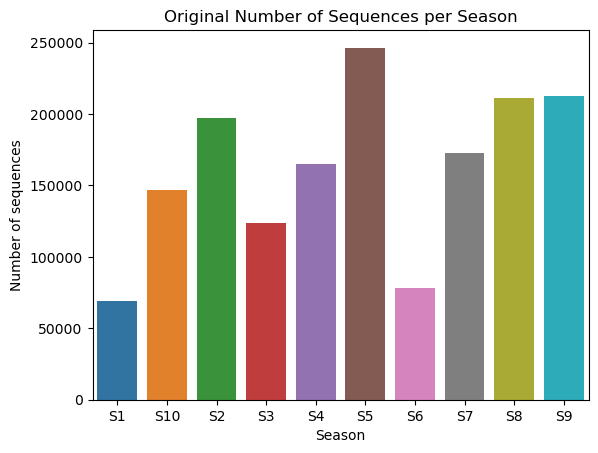

In [5]:
# Read all the annotation from the lakehouse
df = spark.sql("SELECT * FROM workshop_lh.train_annotations WHERE train_annotations.category_id > 1")

# filter out the season, sequence ID, category_id snf image_id
df_train = df.select("season", "seq_id", "category_id", "location", "image_id", "datetime")

# remove image_id wiTH null and duplicates
df_train = df_train.filter(df_train.image_id.isNotNull()).dropDuplicates()

# convert df_train to pandas dataframe
df_train = df_train.toPandas()


plot_season_counts(df_train, "Original Number of Sequences per Season")

We can visualize the number of images we have for each sequence and as below by far most sequesnces have between 1 and 3 images in them

StatementMeta(, 9cc519e4-dd2e-4e51-88e9-d7ddbfe51643, 13, Finished, Available)

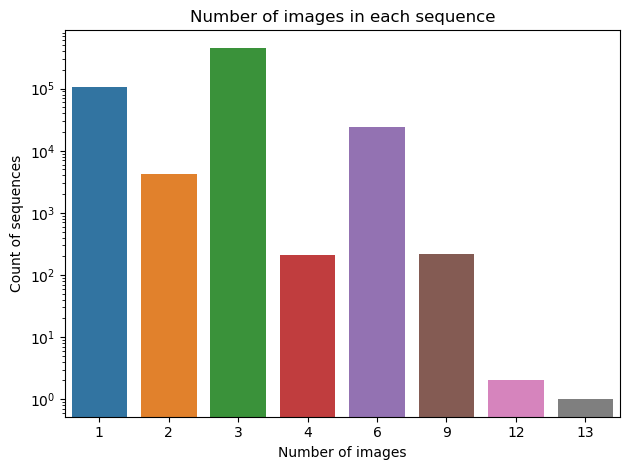

In [6]:
import seaborn as sns

# Create the count plot
ax = sns.countplot(x=df_train.groupby('seq_id').size(), log=True)

# Set the title and axis labels
ax.set_title('Number of images in each sequence')
ax.set_xlabel('Number of images')
ax.set_ylabel('Count of sequences')

# Show the plot
plt.tight_layout()
plt.show()

Load the category names from the Categories table in the lakehouse. We'll then convert the spark dataframe to a pandas dataframe. Next the add a new
column called *label* in the df_train dataframe which is the category name for each category_id. Then remove the category_id column from df_train.

Also rename the image_id column to filename and append the .JPG extension to the the values

In [7]:
import pandas as pd
import numpy as np

# Load the Categories DataFrame into a pandas DataFrame
category_df = spark.sql("SELECT * FROM workshop_lh.categories").toPandas()

# Map category IDs to category names using a vectorized approach
category_map = pd.Series(category_df.name.values, index=category_df.id)
df_train['label'] = category_map[df_train.category_id].values

# Drop the category_id column
df_train = df_train.drop('category_id', axis=1)

# Rename the image_id column to filename
df_train = df_train.rename(columns={'image_id': 'filename'})

# Append the .JPG extension to the filename column
df_train['filename'] = df_train.filename + '.JPG'

StatementMeta(, 9cc519e4-dd2e-4e51-88e9-d7ddbfe51643, 14, Finished, Available)

We'll then pick the first image from each sequence, the assumption is that the time period after a camera trap is triggered is the most likely time for an animal to be in the frame.

In [8]:
# reduce to first frame only for all sequences
df_train = df_train.sort_values('filename').groupby('seq_id').first().reset_index()

df_train.count()

StatementMeta(, 9cc519e4-dd2e-4e51-88e9-d7ddbfe51643, 15, Finished, Available)

seq_id      589758
season      589758
location    589758
filename    589758
datetime    589758
label       589758
dtype: int64

The plot shows the distribution of the labels, where each bar represents the number of images with that label. The y-axis label is set to "Label", and the x-axis label is set to "Number of images". The horizontal orientation of the bars, the increased figure size, the added spacing between the labels, and the logarithmic scale of the x-axis make it easier to read the labels and normalize the distribution.

In [9]:
def plot_label_distribution(df):
    # Create a horizontal bar plot where the y-axis represents the label and the x-axis represents the number of images with that label
    plt.figure(figsize=(8, 12))
    sns.countplot(y='label', data=df, order=df['label'].value_counts().index)
    plt.xlabel('Number of images')
    plt.ylabel('Label')

    # Set the x-axis scale to logarithmic
    plt.xscale('log')

    plt.show()

StatementMeta(, 9cc519e4-dd2e-4e51-88e9-d7ddbfe51643, 16, Finished, Available)

StatementMeta(, 9cc519e4-dd2e-4e51-88e9-d7ddbfe51643, 17, Finished, Available)

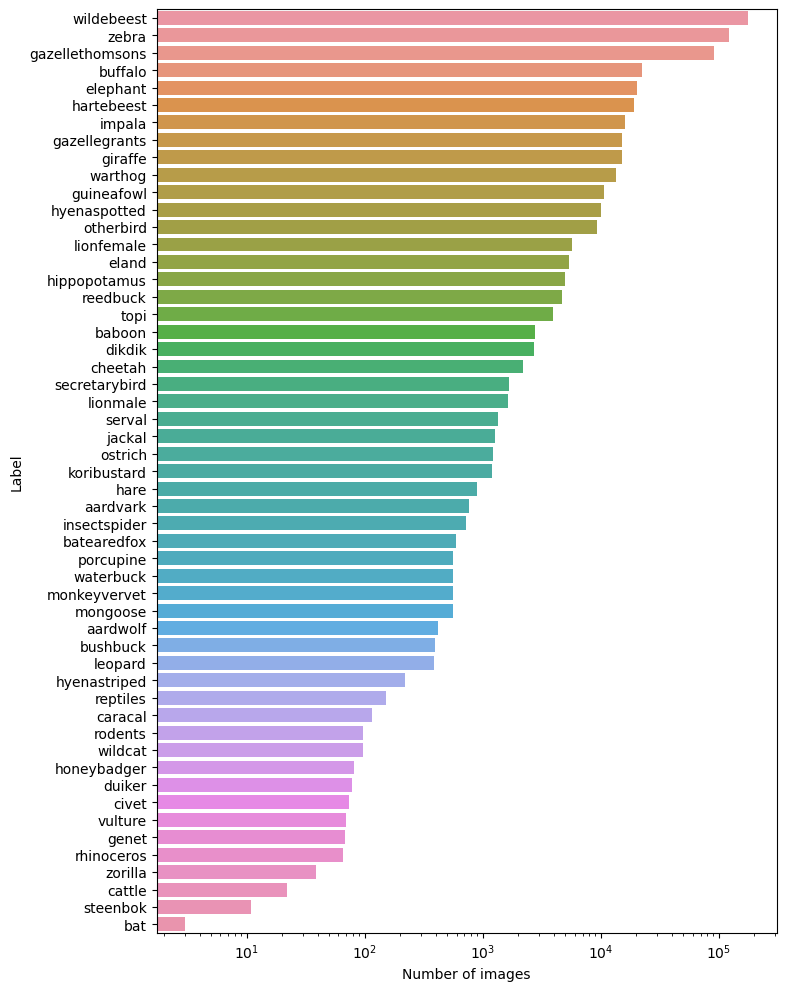

In [10]:
plot_label_distribution(df_train)

Using the file name from the datafram use the defined function that takes the filename as input and returm the url to the image. The function is then applied to the `filename` column of a pandas DataFrame `df_train` to create a new column `image_url` containing the URLs for each image.

In [11]:
# Define a function to apply to the filename column
def get_ImageUrl(filename):
    return f"https://lilablobssc.blob.core.windows.net/snapshotserengeti-unzipped/{filename}"

# Create a new column in the dataframe using the apply method
df_train['image_url'] = df_train['filename'].apply(get_ImageUrl)


StatementMeta(, 9cc519e4-dd2e-4e51-88e9-d7ddbfe51643, 18, Finished, Available)

In [12]:
import urllib.request

def display_random_image(label, random_state, width=500):
    # Filter the DataFrame to only include rows with the specified label
    df_filtered = df_train[df_train['label'] == label]
    
    # Select a random row from the filtered DataFrame
    row = df_filtered.sample(random_state=random_state).iloc[0]
    
    # Load the image from the URL and display it
    url = row['image_url']
    download_and_display_image(url, label)

def download_and_display_image(url, label):
    image = plt.imread(urllib.request.urlopen(url), format='jpg')
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.show()

StatementMeta(, 9cc519e4-dd2e-4e51-88e9-d7ddbfe51643, 19, Finished, Available)

StatementMeta(, 9cc519e4-dd2e-4e51-88e9-d7ddbfe51643, 20, Finished, Available)

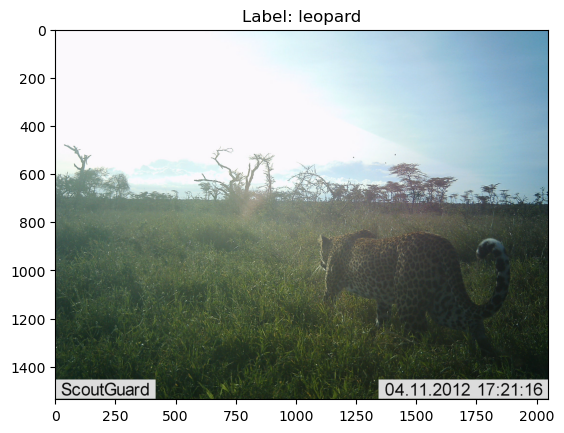

In [13]:
display_random_image(label='leopard', random_state=12)

In [35]:
import urllib.request
import cv2
import concurrent.futures
import imutils

def download_and_resize_image(url, path, kind):
    filename = os.path.basename(path)
    directory = os.path.dirname(path)

    directory_path = f'/lakehouse/default/Files/images/{kind}/{directory}/'

    # Create the directory if it does not exist
    os.makedirs(directory_path, exist_ok=True)

    # check if file already exists
    if os.path.isfile(os.path.join(directory_path, filename)):
        return

    # Download the image
    urllib.request.urlretrieve(url, filename)

    # Read the image using OpenCV
    img = cv2.imread(filename)

    # Resize the image to a reasonable ML training size using imutils
    resized_img = imutils.resize(img, width=224, height=224, inter=cv2.INTER_AREA)

    # Save the resized image to a defined filepath
    cv2.imwrite(os.path.join(directory_path, filename), resized_img)

def execute_parallel_download(df, kind):
    # Use a process pool instead of a thread pool to avoid thread safety issues
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # Batch process images instead of processing them one at a time
        urls = df['image_url'].tolist()
        paths = df['filename'].tolist()
        futures = [executor.submit(download_and_resize_image, url, path, kind) for url, path in zip(urls, paths)]
        # Wait for all tasks to complete
        concurrent.futures.wait(futures)

StatementMeta(, 9cc519e4-dd2e-4e51-88e9-d7ddbfe51643, 42, Finished, Available)

In [15]:
def proportional_allocation_percentage(data, percentage):
    # Calculate the count of the original sample
    original_count = len(data)

    # Calculate the count of the sample based on the percentage
    sample_count = int((percentage / 100) * original_count)

    # Perform proportional allocation on the calculated sample count
    return proportional_allocation(data, sample_count)


def proportional_allocation(data, sample_size):
    # Group the data by "label", "season", and "location" columns
    grouped_data = data.groupby(["label", "season", "location"])

    # Calculate the proportion of each group in the original sample
    proportions = grouped_data.size() / len(data)

    # Calculate the count of each group in the sample based on proportions
    sample_sizes = np.round(proportions * sample_size).astype(int)

    # Calculate the difference between the desired sample size and the sum of rounded sample sizes
    size_difference = sample_size - sample_sizes.sum()

    # Adjust the sample sizes to account for the difference
    if size_difference > 0:
        # If there is a shortage of items, allocate the additional items to the groups with the largest proportions
        largest_proportions = proportions.nlargest(size_difference)
        for group in largest_proportions.index:
            sample_sizes[group] += 1
    elif size_difference < 0:
        # If there is an excess of items, reduce the sample sizes from the groups with the smallest proportions
        smallest_proportions = proportions.nsmallest(-size_difference)
        for group in smallest_proportions.index:
            sample_sizes[group] -= 1

    # Initialize an empty list to store the sample
    sample_data = []

    # Iterate over each group and randomly sample the required count
    for group, count in zip(grouped_data.groups, sample_sizes):
        indices = grouped_data.groups[group]
        sample_indices = np.random.choice(indices, size=count, replace=False)
        sample_data.append(data.loc[sample_indices])

    # Concatenate the sampled dataframes into a single dataframe
    sample_data = pd.concat(sample_data)

    # Reset the index of the sample DataFrame
    sample_data.reset_index(drop=True, inplace=True)

    return sample_data


StatementMeta(, 9cc519e4-dd2e-4e51-88e9-d7ddbfe51643, 22, Finished, Available)

StatementMeta(, 9cc519e4-dd2e-4e51-88e9-d7ddbfe51643, 40, Finished, Available)

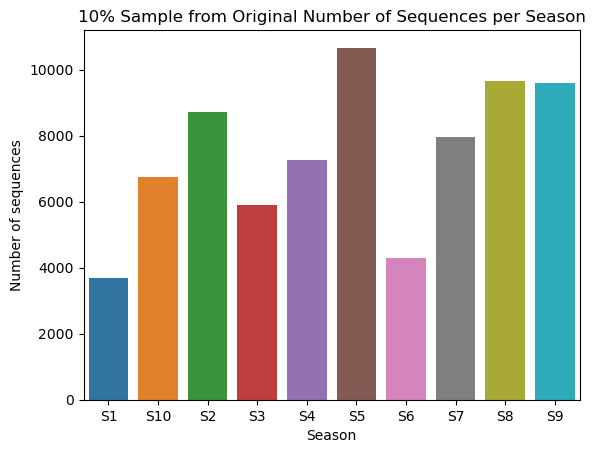

In [33]:
percent = 0.05
sampled_train = proportional_allocation_percentage(df_train, percent)
plot_season_counts(sampled_train, f"{percent}% Sample from Original Number of Sequences per Season")

In [ ]:
import os

train_directory = '/lakehouse/default/Files/images/train/'

file_count = sum(len(files) for _, _, files in os.walk(train_directory))
print('Training images count: '+ str(file_count))


In [ ]:
output_dir = 'Files/data'

# Create the directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

sampled_train.write.format('parquet').mode('overwrite'.save(output_dir))

: 

In [ ]:
sampled_train.loc[:, ['filename', 'label']].to_parquet(data_dir, engine='pyarrow', compression='snappy')